In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42
┌ Info: Precompiling RDatasets [ce6b1742-4840-55fa-b093-852dadbb1d8b]
└ @ Base loading.jl:1317
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [2]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepGateBarA0 (generic function with 1 method)

In [3]:
#getEdepGateBarA0(99, 20)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+80, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
#getEdepGateBarA90(4, 260)

In [6]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [7]:
#getEdepGateGrid(1, 40)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [8]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [9]:
#getEdepOhioBarA0(1)

In [10]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [11]:
#getEdepOhioBarA90(1)

In [12]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = inputArray.-min
    max = maximum(inputArray)/2048
    inputArray = inputArray./max
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [13]:
#normalize(getEdepOhioBarA90(1))

In [14]:
#normalize(getEdepOhioBarA0(1))

In [15]:
function makeTrainingData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*20)
    for i = 1:trainingSize
        for r = 1:20
            trainingArray[:, :, 1, (i-1)*20 + r] = getEdepGateBarA0(i, (r-1)*10 + 80)
            trainingArray[:, :, 2, (i-1)*20 + r] = getEdepGateBarA90(i, (r-1)*10 + 80)
        end
    end
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [16]:
function makeValidationData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*4)
    for i = 1:trainingSize
        for r = 1:4
            trainingArray[:, :, 1, (i-1)*4 + r] = getEdepGateBarA0(i, (r-1)*20)
            trainingArray[:, :, 2, (i-1)*4 + r] = getEdepGateBarA90(i, (r-1)*20)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [17]:
#makeTrainingData()

In [18]:
function makeTargetData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*20)
    for i = 1:trainingSize
        for r = 1:20
            trainingArray[:,(i-1)*20 + r] = getEdepGateGrid(i, (r-1)*10+80)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [19]:
function makeValTargetData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*4)
    for i = 1:trainingSize
        for r = 1:4
            trainingArray[:,(i-1)*4 + r] = getEdepGateGrid(i, (r-1)*20)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [20]:
#makeTargetData()

In [21]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize)
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [22]:
#makeInputData()

In [23]:
trainingArray = makeTrainingData()

8×8×2×2000 Array{Int64, 4}:
[:, :, 1, 1] =
  9170   8358   5422   4006   2562   1218    555    191
 20724  19208  14570  10487   6484   2829    905    293
 42111  48282  40117  31403  19426   9066   2454    516
 32283  54028  71672  80224  68196  37001  10292   1547
 13949  21509  37565  62410  89673  95727  58686  13084
  6226   8960  13750  20601  27373  37069  44280  22398
  2926   4154   5177   7104   7499   7447   5213   1628
  1769   1980   2113   2525   2556   1993   1433    420

[:, :, 2, 1] =
  41   103    201    780  11039   244   82   27
  80   173    373   2800  28343   452  106   58
 153   233    749  11951  43431  1154  160   88
 186   475   1980  33194  46103  1429  333  166
 267   675   4108  56299  36502  1256  223  138
 344   856   7234  73395  23534  1143  208   67
 447  1429  12217  80461  15849  1073  210   72
 564  1757  18567  73273  10101  1000  198  108

[:, :, 1, 2] =
  3407   3652   3504   2943   2108   1229    634    306
  7252   8270   9031   7918   6283   

In [24]:
targetArray = makeTargetData()

512×2000 Matrix{Int64}:
  76   57   41   34   37   10  10    5  …     6     6    10     9     9     8
 124   74   96   43   35   31  26   30       10    49    10    13    11    16
  84  101  119   73   35   25  16   13       26    85    11    26    35    25
  79  117  144  100   42   29  19   22       17    53    13    22    31    13
 102  130  127   97   74   30  15   11        8    30    13    29    30    43
  65  115   99  127   93   47  19   18  …    38    23    55    12    19    21
  93  153   79  140  112   49  23   19        8    11    40    11    13     9
  75   88   30  127  115   30  58  101       15     9    11    14    11    11
 219  168  152  111   59   57  16    4      194   325   298   260   350   332
 337  145  201  120   42   30  32   15      384   637   638   533   263   266
 413  283  251  273   96   37  16   18  …   614   760   811   657   340   217
 349  345  415  267  113  103  57   31      542   703   395   495   331   334
 318  396  414  307  139  154  63   25  

In [25]:
validationArray = makeValidationData()

8×8×2×400 Array{Int64, 4}:
[:, :, 1, 1] =
 156  602  3357  47177  49641  3200  553  319
 173  487  3189  50404  52208  2689  436  185
 118  408  2431  47899  48697  2149  378  125
 104  346  1692  41691  42963  1698  407  121
  80  236  1260  35193  34956  1046  276   91
  74  159   666  25635  25201   441  157   90
  71  149   388  15401  14209   307  130   68
  47   82   169   5458   5147   167   93   60

[:, :, 2, 1] =
  9170   8358   5422   4006   2562   1218    555    191
 20724  19208  14570  10487   6484   2829    905    293
 42111  48282  40117  31403  19426   9066   2454    516
 32283  54028  71672  80224  68196  37001  10292   1547
 13949  21509  37565  62410  89673  95727  58686  13084
  6226   8960  13750  20601  27373  37069  44280  22398
  2926   4154   5177   7104   7499   7447   5213   1628
  1769   1980   2113   2525   2556   1993   1433    420

[:, :, 1, 2] =
 397  1912  18263  73657  10080   907  245   70
 479  1689  13766  82490  16289  1328  273   88
 406  1238   7

In [26]:
validationTargetArray = makeValTargetData()

512×400 Matrix{Int64}:
  5  31   73   95  25  25   24  108  16  …   230   207   11   55   252   306
  3  38   52  117   5  25   29   88   2      119   372    9   66   237   319
  9  17   20   63   5  37   36   75   6       96   315   33   50   219   259
 10  13   15  100   5   9   24   58   6       43   289    9  112   110   252
  2   7   10   70   2   5   26   41   4       53   193   10   43    42   225
  4   7   19   59   0   5   10   30   2  …    30   176    5   35    22    99
  8   3    7   40   3   5   27   24   0       13   197    7   33    18    84
  1   6    9   16   2   1   30   24   0       10    44    1   18    41    38
  8  34  117  328  26  46  136  275  27     1853  1295  106  873  1952  1395
  8  26   96  233  11  68  110  271  11     2066  1626  130  565  2062  1617
 10  31   92  269  16  63   64  250  39  …  1567  2275   72  329  1777  1849
  5  14   48  287  20  18   59  216  20      700  2199   57  198  1176  2130
 25   6   42  205  10  12   79  182  19      254  216

In [27]:
inputArray = makeInputData()

8×8×2×21 Array{Int64, 4}:
[:, :, 1, 1] =
 38484  42128  52850  126117  208366  54216  42413  38391
 39382  44555  47446  118228  285328  61556  41870  39128
 36595  39956  55851  189571  294911  57231  42411  38908
 38021  43502  45917  122588  483994  71271  40778  39157
 40115  46611  55757  176140  345909  74524  42913  39929
 39228  38664  58439  162217  244550  68536  43572  39139
 37466  37933  56898  131986  361086  60613  48624  37953
 35604  38155  43116   84692  184161  70698  43053  37902

[:, :, 2, 1] =
 19404  22059  44432  101296   77978  36257  21430  19332
 20006  24228  42568   87020  105097  53825  21343  20054
 17905  20826  56275  160868  105372  47073  21694  19664
 19379  23974  36643   91733  144345  65212  20635  20134
 20977  26756  56546  140444  126791  68834  22822  20629
 20002  20012  61299  128934   87739  61529  22612  20076
 18627  19083  62967   99105  119800  47310  25929  19225
 17006  19348  31036   58054   65617  59364  22150  18946

[:, :, 1, 2] =

In [28]:
function plotResults(m)
    image = rand((1: size(inputArray)[4]))
    print(image)
    display(heatmap(reshape(m(validationArray)[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(m(inputArray)[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [29]:
#plotResults(m)

In [30]:
m = Chain(Conv((2,2), 2=>16, pad=(1,1), relu),
        x -> reshape(x, :, size(x,4)), 

        Dense(1296, 1800),

        Dense(1800, 8*8*8))

Chain(Conv((2, 2), 2=>16, relu), #21, Dense(1296, 1800), Dense(1800, 512))

In [31]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM()
dataset = (repeated((trainingArray, targetArray), 100))
evalcb = () -> @show (loss(trainingArray, targetArray)) 
CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = Int64
│   T2 = Float32
└ @ NNlib /home/jupyter-nrmeskell/.julia/packages/NNlib/3MZcC/src/conv.jl:206


Training R2: 6.4076682699809595e-6
Validation R2: 0.0002967324640208435


┌ Warning: Slow fallback implementation invoked for ∇conv_filter!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = Int64
│   T2 = Float32
└ @ NNlib /home/jupyter-nrmeskell/.julia/packages/NNlib/3MZcC/src/conv.jl:206


loss(trainingArray, targetArray) = 6.3915692f7
loss(trainingArray, targetArray) = 6.7097355f6
loss(trainingArray, targetArray) = 3.5145585f6
loss(trainingArray, targetArray) = 2.6260365f6
loss(trainingArray, targetArray) = 2.313692f6
loss(trainingArray, targetArray) = 2.1718708f6
loss(trainingArray, targetArray) = 2.103161f6
loss(trainingArray, targetArray) = 2.0638635f6
loss(trainingArray, targetArray) = 2.0375988f6
loss(trainingArray, targetArray) = 2.0180842f6
Training R2: 0.894310149509129
Validation R2: 0.30099904777243003
9

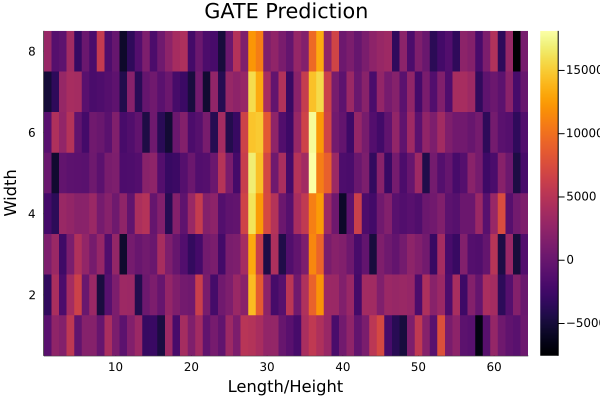

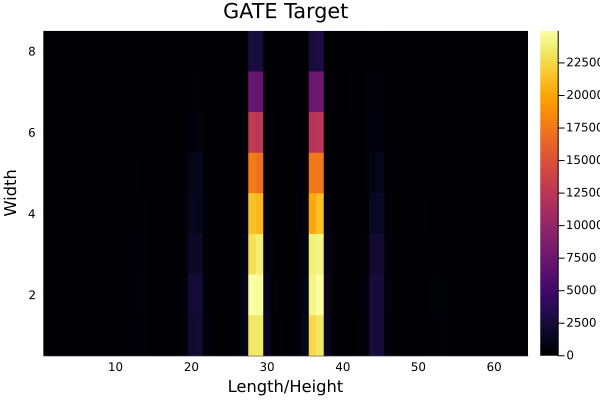

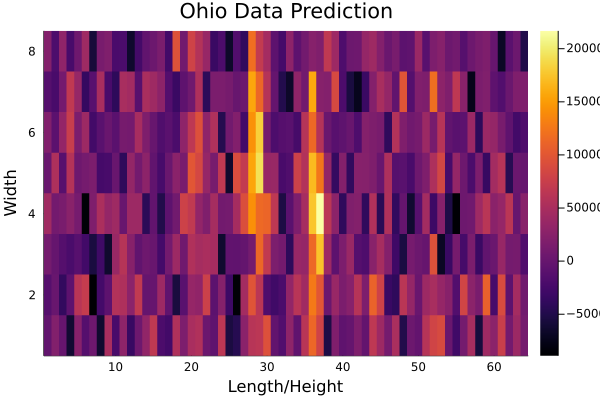

loss(trainingArray, targetArray) = 2.0165119f6
loss(trainingArray, targetArray) = 2.0040576f6
loss(trainingArray, targetArray) = 1.9914164f6
loss(trainingArray, targetArray) = 1.9809622f6
loss(trainingArray, targetArray) = 1.9721679f6
loss(trainingArray, targetArray) = 1.9646299f6
loss(trainingArray, targetArray) = 1.9580959f6
loss(trainingArray, targetArray) = 1.9523508f6
loss(trainingArray, targetArray) = 1.9472481f6
loss(trainingArray, targetArray) = 1.9426662f6


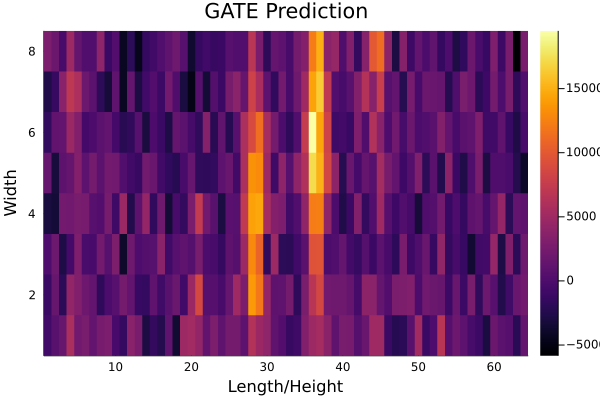

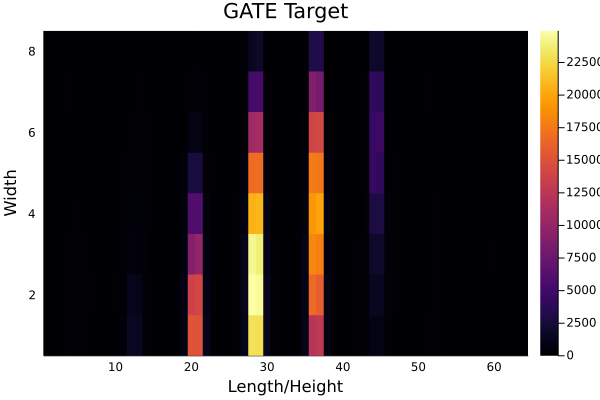

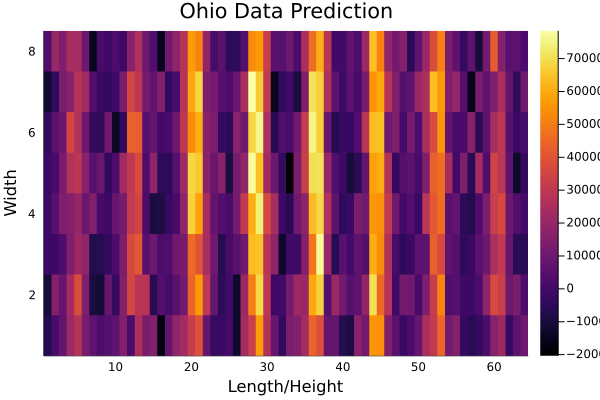

Training R2: 0.9006293448739213
Validation R2: 0.35436211561728403
14loss(trainingArray, targetArray) = 1.9415021f6
loss(trainingArray, targetArray) = 1.9374971f6
loss(trainingArray, targetArray) = 1.9338518f6
loss(trainingArray, targetArray) = 1.9304972f6
loss(trainingArray, targetArray) = 1.9273902f6
loss(trainingArray, targetArray) = 1.9245015f6
loss(trainingArray, targetArray) = 1.9217928f6
loss(trainingArray, targetArray) = 1.9192419f6
loss(trainingArray, targetArray) = 1.9168271f6
loss(trainingArray, targetArray) = 1.9145324f6
Training R2: 0.9033577854348163


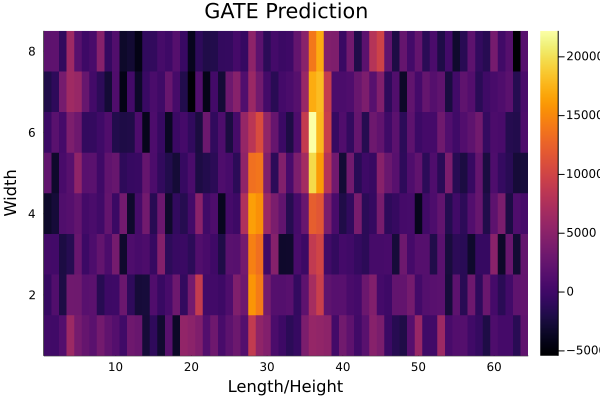

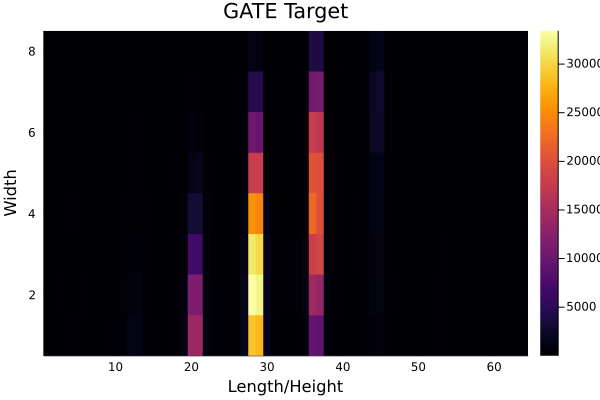

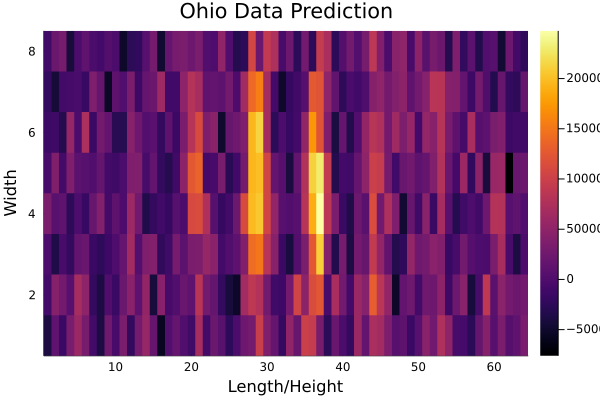

Validation R2: 0.40309846599819343
10loss(trainingArray, targetArray) = 1.9143294f6
loss(trainingArray, targetArray) = 1.9121255f6
loss(trainingArray, targetArray) = 1.9100151f6
loss(trainingArray, targetArray) = 1.9079675f6
loss(trainingArray, targetArray) = 1.9059886f6
loss(trainingArray, targetArray) = 1.9040886f6
loss(trainingArray, targetArray) = 1.9402235f6
loss(trainingArray, targetArray) = 1.9018578f6
loss(trainingArray, targetArray) = 1.9193364f6
loss(trainingArray, targetArray) = 1.9022686f6
Training R2: 0.9054472984743374
Validation R2: 0.45073914481413324

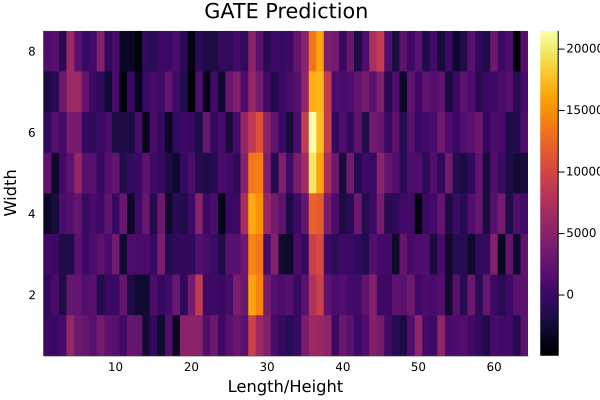

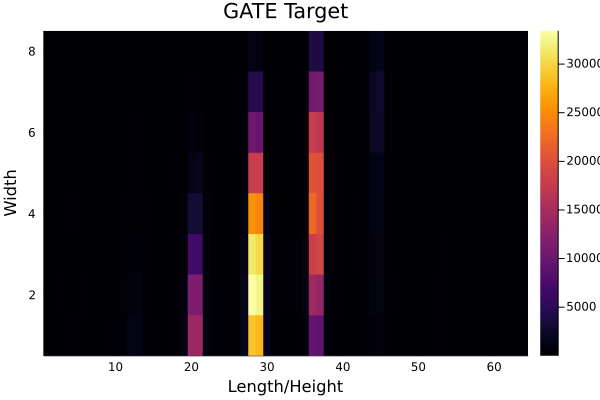

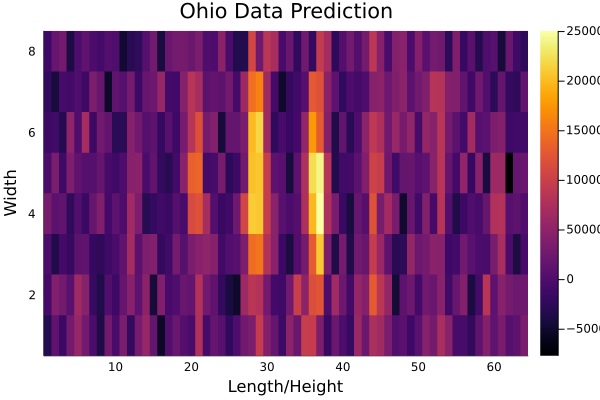


10loss(trainingArray, targetArray) = 1.9054805f6
loss(trainingArray, targetArray) = 1.8967888f6
loss(trainingArray, targetArray) = 1.8939514f6
loss(trainingArray, targetArray) = 1.8921696f6
loss(trainingArray, targetArray) = 1.8903951f6
loss(trainingArray, targetArray) = 1.8886789f6
loss(trainingArray, targetArray) = 1.8869756f6
loss(trainingArray, targetArray) = 1.8852788f6
loss(trainingArray, targetArray) = 1.8835758f6
loss(trainingArray, targetArray) = 1.8818491f6
Training R2: 0.9079869447496369


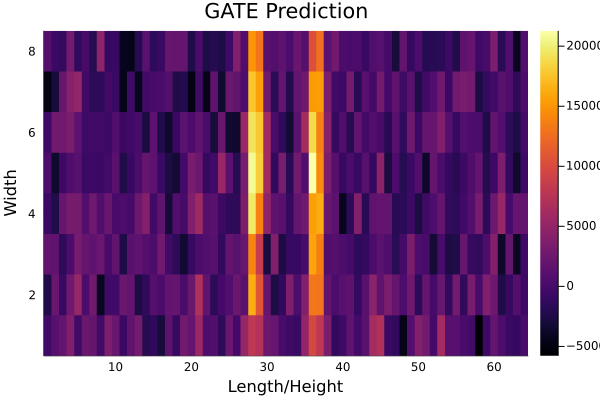

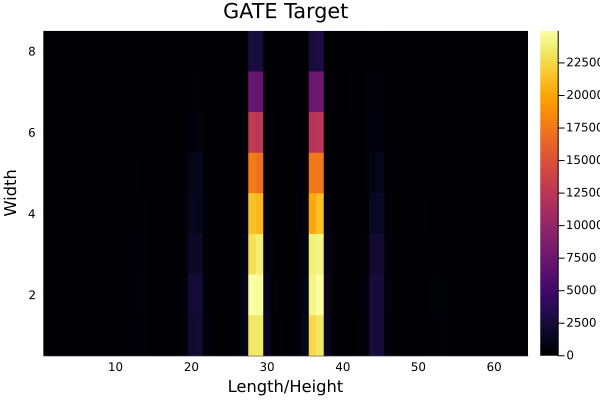

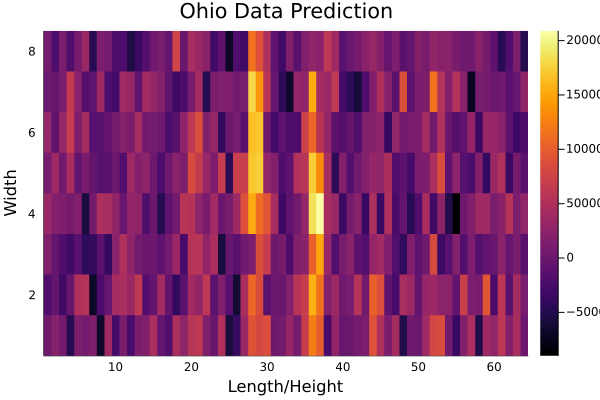

Validation R2: 0.49312757898615056
9loss(trainingArray, targetArray) = 1.881717f6
loss(trainingArray, targetArray) = 1.8799591f6
loss(trainingArray, targetArray) = 1.8781982f6
loss(trainingArray, targetArray) = 1.8764142f6
loss(trainingArray, targetArray) = 1.8745926f6
loss(trainingArray, targetArray) = 1.8727516f6
loss(trainingArray, targetArray) = 1.8709038f6
loss(trainingArray, targetArray) = 1.868993f6
loss(trainingArray, targetArray) = 1.8670334f6


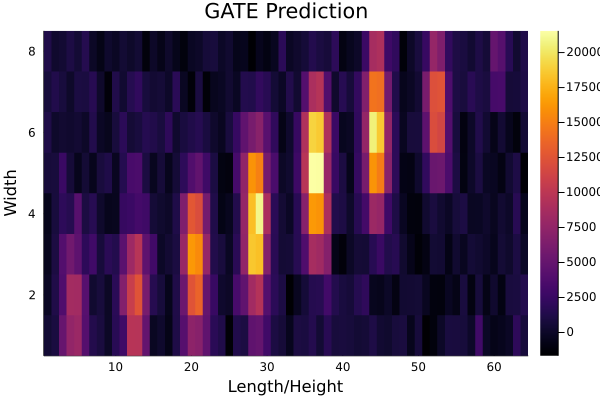

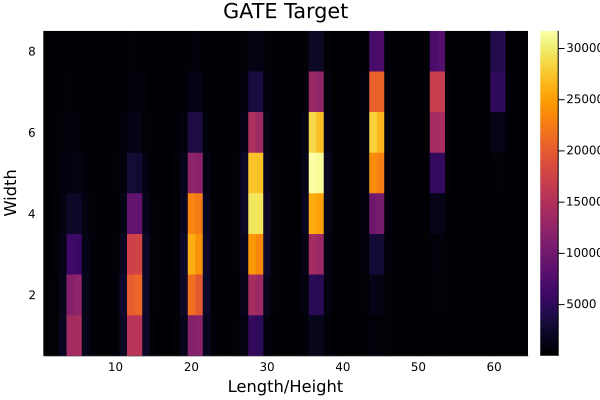

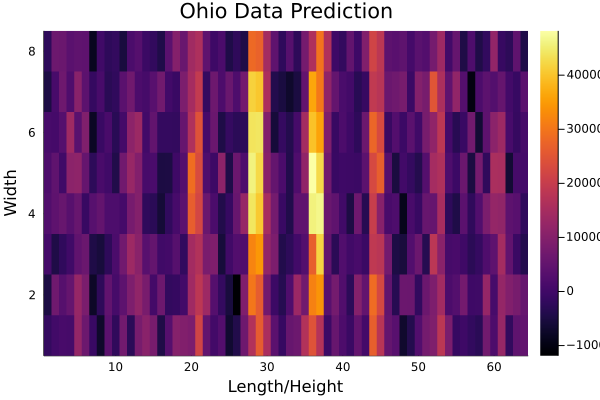

loss(trainingArray, targetArray) = 1.8651928f6
Training R2: 0.91153393504865
Validation R2: 0.5272145218606613
12loss(trainingArray, targetArray) = 1.8651529f6
loss(trainingArray, targetArray) = 2.9437728f6
loss(trainingArray, targetArray) = 1.9925596f6
loss(trainingArray, targetArray) = 1.8946655f6
loss(trainingArray, targetArray) = 1.8770878f6
loss(trainingArray, targetArray) = 1.8708516f6
loss(trainingArray, targetArray) = 1.8674988f6
loss(trainingArray, targetArray) = 1.8651166f6
loss(trainingArray, targetArray) = 1.8630348f6


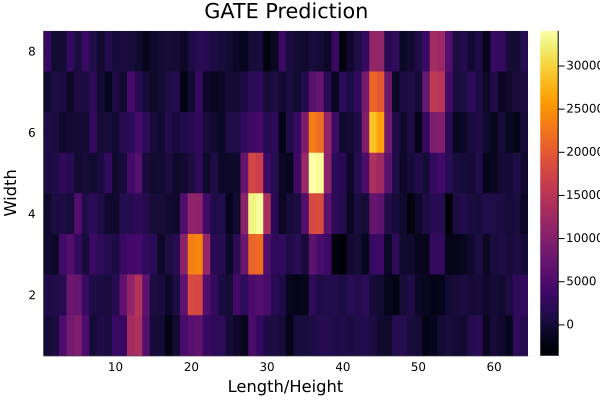

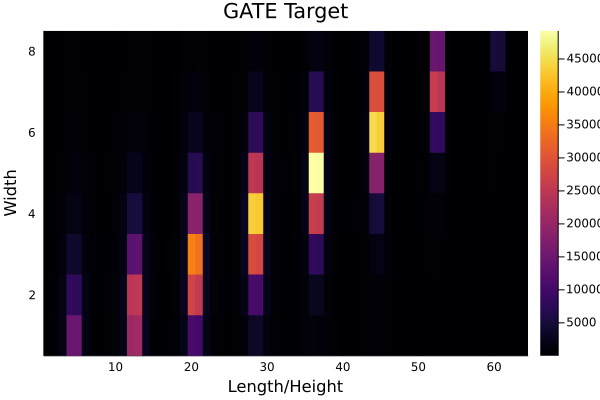

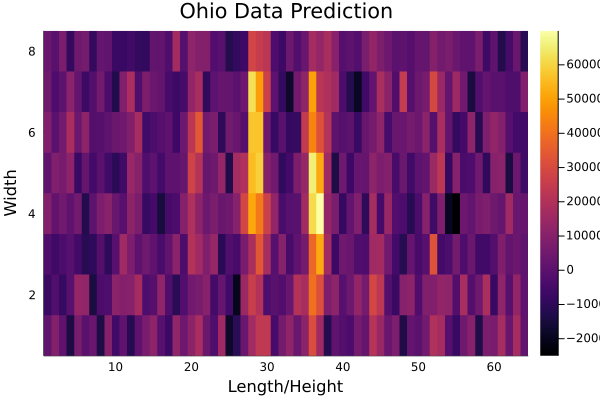

loss(trainingArray, targetArray) = 1.8610238f6
Training R2: 0.9115383863495219
Validation R2: 0.5377829948924958
4loss(trainingArray, targetArray) = 1.8608431f6
loss(trainingArray, targetArray) = 1.8588084f6
loss(trainingArray, targetArray) = 1.8567485f6
loss(trainingArray, targetArray) = 1.8546392f6
loss(trainingArray, targetArray) = 1.8524779f6
loss(trainingArray, targetArray) = 1.8502681f6
loss(trainingArray, targetArray) = 1.8479921f6
loss(trainingArray, targetArray) = 1.8456646f6
loss(trainingArray, targetArray) = 1.8432786f6


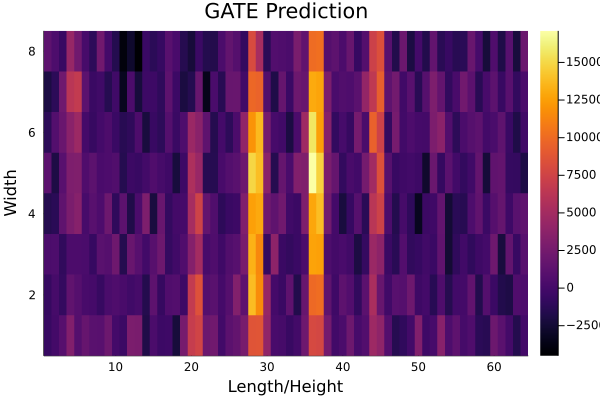

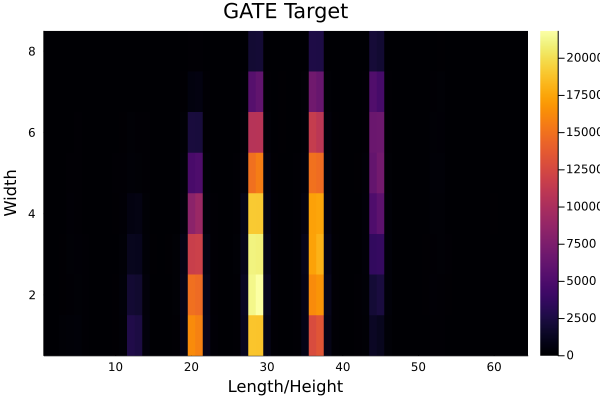

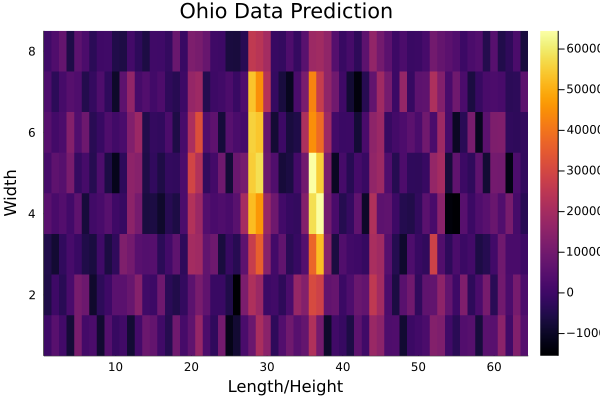

loss(trainingArray, targetArray) = 1.8408282f6
Training R2: 0.9154968329535739
Validation R2: 0.5573082973931729
18loss(trainingArray, targetArray) = 1.8406019f6
loss(trainingArray, targetArray) = 1.870586f6
loss(trainingArray, targetArray) = 2.250601f6
loss(trainingArray, targetArray) = 1.9425898f6
loss(trainingArray, targetArray) = 1.8969324f6
loss(trainingArray, targetArray) = 1.8776656f6
loss(trainingArray, targetArray) = 1.8695158f6
loss(trainingArray, targetArray) = 1.8650631f6
loss(trainingArray, targetArray) = 1.8617229f6


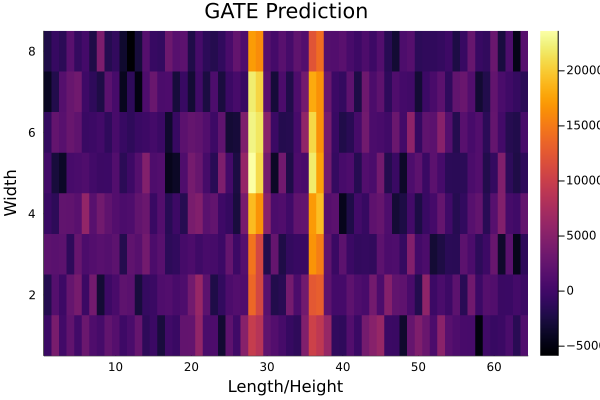

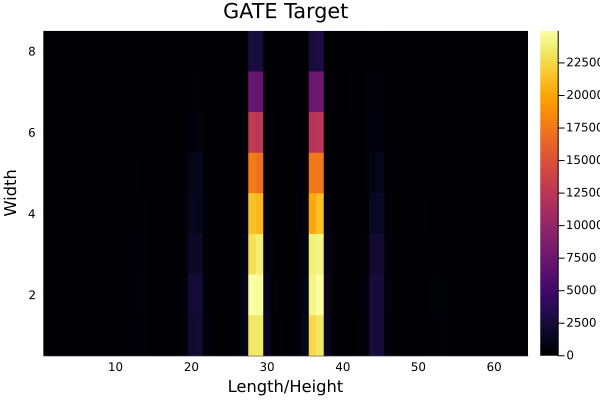

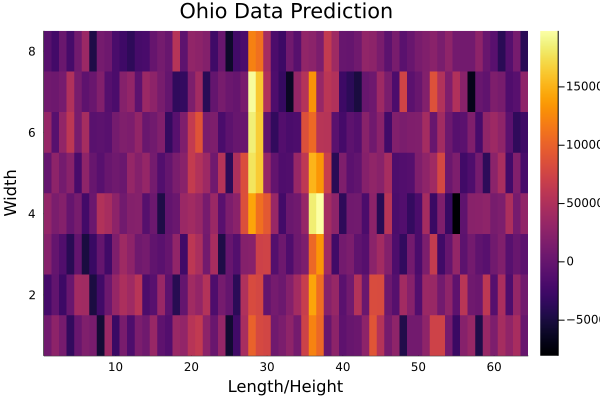

loss(trainingArray, targetArray) = 1.8588254f6
Training R2: 0.9101249479455058
Validation R2: 0.4993680883887791
9loss(trainingArray, targetArray) = 1.8585718f6
loss(trainingArray, targetArray) = 1.8558284f6
loss(trainingArray, targetArray) = 1.8531205f6
loss(trainingArray, targetArray) = 1.8504204f6
loss(trainingArray, targetArray) = 1.8476895f6
loss(trainingArray, targetArray) = 1.8449174f6
loss(trainingArray, targetArray) = 1.8421286f6
loss(trainingArray, targetArray) = 1.8392735f6
loss(trainingArray, targetArray) = 1.8363374f6
loss(trainingArray, targetArray) = 1.8371948f6
Training R2: 0.917190696432418


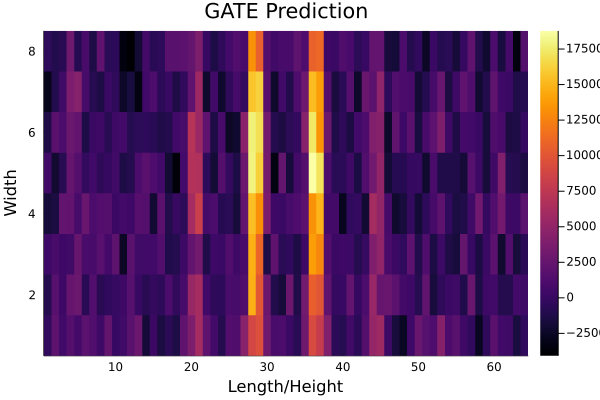

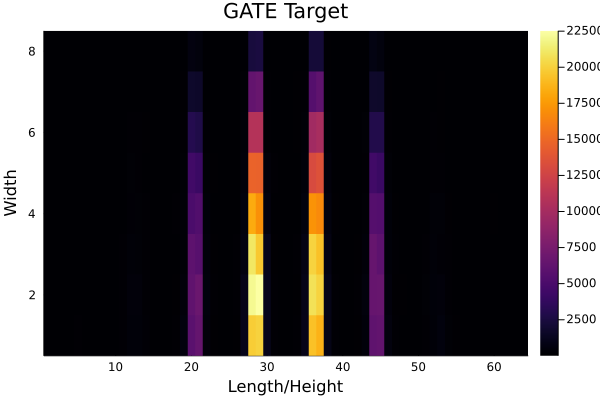

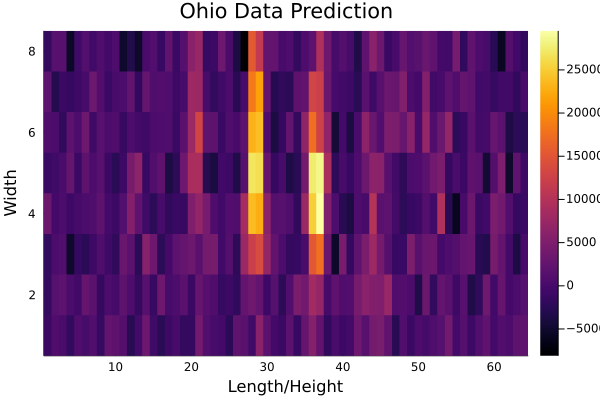

Validation R2: 0.5312600342993463
17

In [32]:
for i = 1:10
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 2))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    plotResults(m)
end

In [33]:
function writeOutput(m)
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    mkdir(string(path, "/Run", runNumber))
    path = string(path, "/Run", runNumber)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
    for i = 1:size(validationTargetArray)[2]
        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"),".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(validationArray)[:,i], (8*8,8)))), " ")
    end
    
    for i = 1:size(O)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(validationArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)